In [2]:
! pip install numpy
! pip install pandas
! pip install seaborn
! pip install scikit-learn
! pip install matplotlib
! pip install tensorflow
! pip install keras
! pip install sgp4
! pip install scipy

! pip install openpyxl


ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [3]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sgp4.api import Satrec
from scipy.spatial.transform import Rotation as R

# TLE da ISS
line1 = "1 25544U 98067A   24106.45347222  .00012190  00000+0  21377-3 0  9992"
line2 = "2 25544  51.6414  52.8843 0003046  96.6780  42.0736 15.51762384294959"
sat = Satrec.twoline2rv(line1, line2)

# Função auxiliar
def datetime_to_julian_date(dt):
    year, month, day = dt.year, dt.month, dt.day
    hour, minute, second = dt.hour, dt.minute, dt.second + dt.microsecond / 1e6
    jd = 367 * year - int((7 * (year + int((month + 9) / 12))) / 4) \
         + int((275 * month) / 9) + day + 1721013.5 \
         + (hour + minute / 60 + second / 3600) / 24
    fr = (hour + minute / 60 + second / 3600) / 24 % 1
    return jd, fr

# Parâmetros
base_time = datetime.utcnow()
intervalo_segundos = 30
samples = 200
tempos, q0, q1, q2, q3 = [], [], [], [], []
rolls, pitchs, yaws = [], [], []

# Loop de propagação
for i in range(samples):
    dt = base_time + timedelta(seconds=i * intervalo_segundos)
    jd, fr = datetime_to_julian_date(dt)
    err, position, velocity = sat.sgp4(jd, fr)

    if err != 0:
        print(f"Erro na propagação para t={dt}, código: {err}")
        continue

    r = np.array(position)
    v = np.array(velocity)

    z = -r / np.linalg.norm(r)
    y = np.cross(z, v); y /= np.linalg.norm(y)
    x = np.cross(y, z)
    rot_matrix = np.vstack([x, y, z]).T
    rotation = R.from_matrix(rot_matrix)

    quat = rotation.as_quat()   # x, y, z, w
    euler = rotation.as_euler('xyz', degrees=True)

    tempos.append(i * intervalo_segundos)
    q0.append(quat[3]); q1.append(quat[0]); q2.append(quat[1]); q3.append(quat[2])
    rolls.append(euler[0]); pitchs.append(euler[1]); yaws.append(euler[2])

# Rotulagem automática
def rotular_gimbal_lock(pitch, tolerancia=2):
    if abs(pitch - 90) < tolerancia:
        return "gimbal_lock"
    elif abs(pitch - 90) < tolerancia + 5:
        return "alerta"
    else:
        return "ok"

# DataFrame final
df = pd.DataFrame({
    'tempo': tempos,
    'q0': q0, 'q1': q1, 'q2': q2, 'q3': q3,
    'roll': rolls,
    'pitch': pitchs,
    'yaw': yaws
})
df['status'] = df['pitch'].apply(rotular_gimbal_lock)

print(df.head())
df.to_excel("dados_orientacao_IA.xlsx", index=False) # visualização


C:\Users\jaysa.gabrielly\AppData\Local\Temp\ipykernel_11136\1184290778.py:23: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  base_time = datetime.utcnow()


   tempo        q0        q1        q2        q3        roll      pitch  \
0      0 -0.378901  0.824332  0.005065  0.420576 -120.062239 -44.204954   
1     30 -0.378517  0.838219  0.017987  0.392160 -123.190789 -42.148092   
2     60 -0.377692  0.851129  0.030887  0.363282 -125.996333 -39.921066   
3     90 -0.376426  0.863046  0.043750  0.333976 -128.496581 -37.546907   
4    120 -0.374722  0.873957  0.056561  0.304276 -130.712343 -35.046203   

         yaw status  
0 -25.655224     ok  
1 -21.084991     ok  
2 -16.813517     ok  
3 -12.819458     ok  
4  -9.078134     ok  


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

df = pd.read_excel("dados_orientacao_IA.xlsx")

# Rótulo automático com base no pitch
def rotulo(pitch):
    if abs(pitch - 90) < 2:
        return 'gimbal_lock'
    elif abs(pitch - 90) < 7:
        return 'alerta'
    else:
        return 'ok'

df['status'] = df['pitch'].apply(rotulo)

# Dados sintéticos de alerta e gimbal_lock
df_fake = pd.DataFrame({
    'tempo': range(30),
    'q0': np.random.uniform(-1, 1, 30),
    'q1': np.random.uniform(-1, 1, 30),
    'q2': np.random.uniform(-1, 1, 30),
    'q3': np.random.uniform(-1, 1, 30),
    'roll': np.random.uniform(-180, 180, 30),
    'pitch': np.concatenate([
        np.full(10, 90),     # gimbal_lock
        np.full(10, 88),     # alerta (|pitch - 90| = 2)
        np.full(10, 100)     # ok (|pitch - 90| = 10)
    ]),
    'yaw': np.random.uniform(-180, 180, 30)
})

df_fake['status'] = df_fake['pitch'].apply(rotulo)

# Junta os dados
df = pd.concat([df, df_fake], ignore_index=True)



# Codifica os rótulos
encoder = LabelEncoder()
y_raw = encoder.fit_transform(df['status'])
print("Distribuição dos rótulos gerados:\n", df['status'].value_counts())
print("Rótulos codificados:", encoder.classes_)

# Seleciona as features e define janela
features = ['q0', 'q1', 'q2', 'q3', 'roll', 'pitch', 'yaw']
window_size = 10

X, y = [], []
for i in range(len(df) - window_size):
    seq_x = df[features].iloc[i:i+window_size].values
    label = y_raw[i + window_size]
    X.append(seq_x)
    y.append(label)

X = np.array(X)
y = np.array(y)
y_cat = to_categorical(y)

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# Modelo LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(window_size, len(features))))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Treinamento
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Avaliação
loss, acc = model.evaluate(X_test, y_test)
print(f"\n✅ Acurácia: {acc:.2f} | Loss: {loss:.4f}")

# ---------- Mtriz de Confusão ----------
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Fazer previsões no conjunto de teste
y_pred_prob = model.predict(X_test)
y_pred = y_pred_prob.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# 2. Matriz
cm = confusion_matrix(y_true, y_pred)
labels = encoder.classes_  # classes originais ['gimbal_lock', 'ok', 'alerta'] por exemplo

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Matriz de Confusão")
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.show()

# 3. Relatório de Classificação
print("Relatório de Classificação:\n")
print(classification_report(y_true, y_pred, target_names=labels))

# 4. Testar previsão em novas amostras (exemplo: últimas sequências do conjunto de teste)
print("\nExemplo de previsões para novas sequências:\n")
for i in range(5):
    sample = X_test[i][np.newaxis, ...]
    pred_prob = model.predict(sample)[0]
    pred_class = encoder.inverse_transform([pred_prob.argmax()])[0]
    print(f"Amostra {i+1}: Classe prevista = {pred_class}, Probabilidades = {pred_prob}")
# --------------------------------------

# Visualização
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title("Acurácia durante o Treinamento")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.grid(True)
plt.show()


ModuleNotFoundError: No module named 'tensorflow'

In [18]:
# para salvar os dados
# extensão: H5Web
from tensorflow.keras.models import load_model
model.save("modelo_gimbal_lock.h5")

# model = load_model("modelo_gimbal_lock.h5")

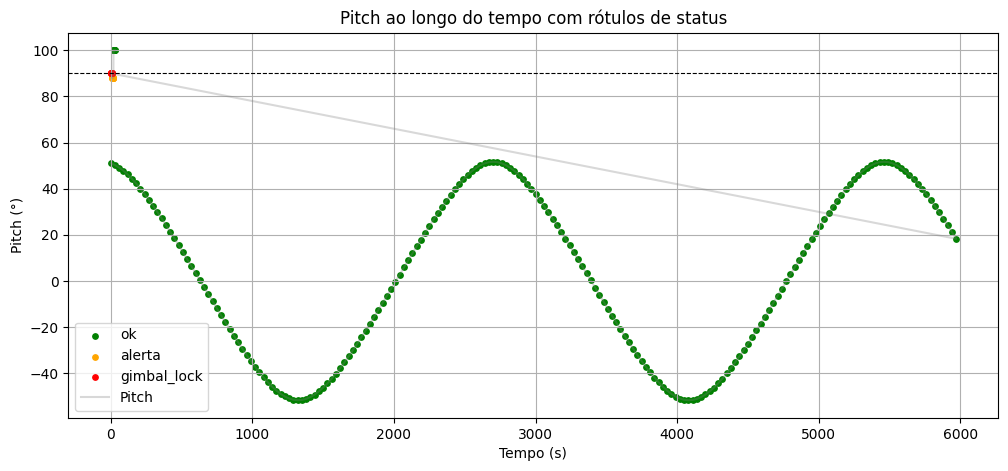

In [15]:
import matplotlib.pyplot as plt

cores = {'ok': 'green', 'alerta': 'orange', 'gimbal_lock': 'red'}

plt.figure(figsize=(12, 5))
for status, cor in cores.items():
    subset = df[df['status'] == status]
    plt.scatter(subset['tempo'], subset['pitch'], label=status, color=cor, s=15)

plt.plot(df['tempo'], df['pitch'], color='gray', alpha=0.3, label='Pitch')
plt.axhline(90, color='black', linestyle='--', linewidth=0.8)
plt.title("Pitch ao longo do tempo com rótulos de status")
plt.xlabel("Tempo (s)")
plt.ylabel("Pitch (°)")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
for i in range(5):
    sample = X_test[i][np.newaxis, ...]
    pred_prob = model.predict(sample)[0]
    pred_class = encoder.inverse_transform([pred_prob.argmax()])[0]
    
    print(f"\n🛰️ Amostra {i+1} - Classe prevista: {pred_class}")
    print(f"Probabilidades: {pred_prob}")
    print("Sequência de pitchs:")
    print(X_test[i][:, features.index('pitch')])  # extrai os valores de pitch da sequência

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

🛰️ Amostra 1 - Classe prevista: ok
Probabilidades: [3.9814444e-05 1.1897079e-04 9.9984121e-01]
Sequência de pitchs:
[-48.92394067 -50.07311555 -50.92466862 -51.45819777 -51.65995627
 -51.52446108 -51.05517207 -50.26405355 -49.1701415  -47.79749399]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

🛰️ Amostra 2 - Classe prevista: ok
Probabilidades: [2.6109116e-04 4.6538917e-04 9.9927348e-01]
Sequência de pitchs:
[-32.59906796 -29.90274993 -27.12708851 -24.2843327  -21.38521577
 -18.43919759 -15.45468548 -12.43923206  -9.39971142  -6.34247654]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step

🛰️ Amostra 3 - Classe prevista: ok
Probabilidades: [9.3898547e-05 1.0049173e-04 9.9980563e-01]
Sequência de pitchs:
[50.22067511 49.11409185 47.73061671 46.09736293 44.24216592 42.19209809
 39.97249015 37.60640588 35.11443924 32.51475317]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

🛰️ Amostra 4 - Classe prevista: ok
Probabilidades: [9.1987145e-05 2.7121781e-04 9.9963677e-01]
Sequência de

In [17]:
print(f"\n🔎 Avaliação Final:")
print(f"Acurácia: {acc:.2f} | Loss: {loss:.4f}")
print("\nMatriz de Confusão e Classificação:")
print(classification_report(y_true, y_pred, target_names=labels))


🔎 Avaliação Final:
Acurácia: 0.89 | Loss: 0.3430

Matriz de Confusão e Classificação:
              precision    recall  f1-score   support

      alerta       0.00      0.00      0.00         2
 gimbal_lock       0.67      0.50      0.57         4
          ok       0.95      0.97      0.96        38

    accuracy                           0.89        44
   macro avg       0.54      0.49      0.51        44
weighted avg       0.88      0.89      0.88        44

